In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import missingno as msno
import matplotlib.pyplot as plt
import joblib
pd.set_option('display.max_columns', None)
import os
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity  # Calculating cosine similarity between vectors

import tensorflow as tf  # TensorFlow library for machine learning
from tensorflow.keras.models import Sequential  # Sequential model from Keras
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout  # Layers for the neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

!pip install scikit-surprise
!pip install mlflow



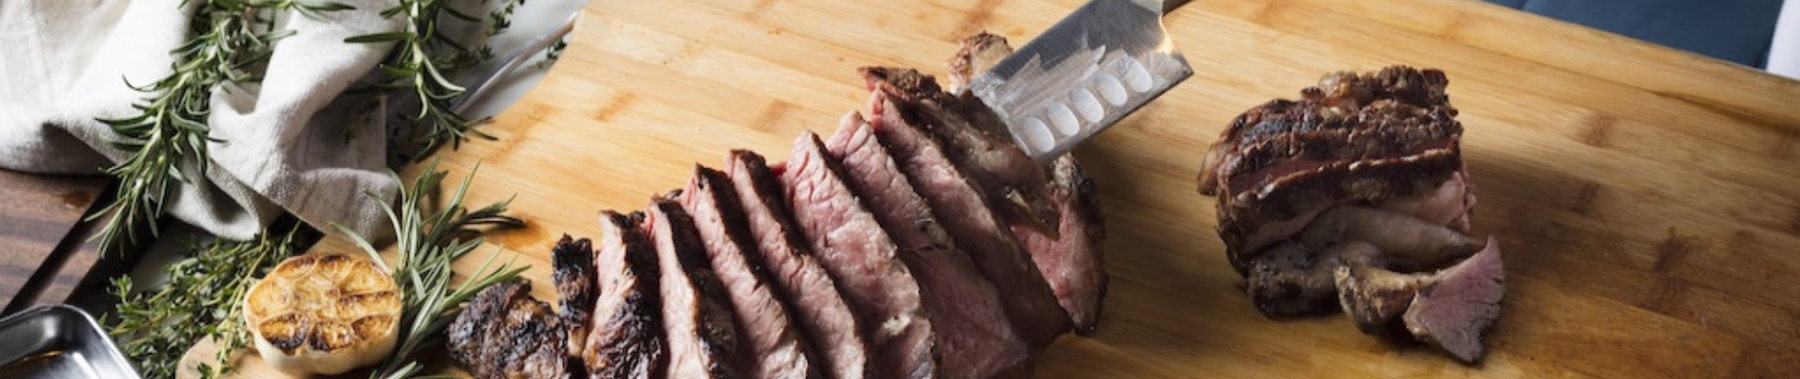
https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
- 1,401,982 reviews from 271,907 different users
- 522,517 recipes from 312 different categories

# Data Collection

## Read  2 Datasets

In [183]:
Recipe=pd.read_csv('../datasets/recipes.csv')
Recipe.head(2)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


## Drop unrelated columns from reciepe data

In [185]:
Recipe.drop(['DatePublished','AuthorName','Images',"TotalTime","CookTime","PrepTime"],axis=1,inplace=True)
Recipe.head(2)

,RecipeId,Name,AuthorId,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,Make and share this Biryani recipe from Food.com.,Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


### Team notes (Hany)
- Review data
- We can use Images after finishing to do cv

In [187]:
Review=pd.read_csv('../datasets/reviews.csv')
Review.head(2)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z


In [188]:
Review["AuthorId"].value_counts()

AuthorId
424680        8842
37449         6605
383346        5438
128473        4693
169430        4586
              ... 
1701969          1
1585419          1
1704446          1
1417548          1
2002812127       1
Name: count, Length: 271907, dtype: int64

In [189]:
# Hany

- We dont need all those people that made one review

In [191]:
(Review["AuthorId"].value_counts() >= 20).sum()

8213

- Number of people that review at least 20 review

## Filtering

In [194]:
filtered_users = Review.groupby('AuthorId').size().reset_index(name='ReviewCount')
filtered_users = filtered_users[filtered_users['ReviewCount'] >= 30]
filtered_users

,AuthorId,ReviewCount
0,1533,153
1,1535,1044
4,1634,79
5,1676,38
8,1792,38
...,...,...
254226,2002169932,84
257539,2002256447,104
259858,2002321540,57
261562,2002404048,76


In [195]:
filtered_review = Review[Review['AuthorId'].isin(filtered_users['AuthorId'])]
filtered_review

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
21,47,780,2312,Gay Gilmore,5,This was delicious.\r\n,2000-09-12T22:49:36Z,2000-09-12T22:49:36Z
25,53,51964,2312,Gay Gilmore,5,This dish was lovely. All my guests complimen...,2000-09-26T21:19:02Z,2000-09-26T21:19:02Z
29,59,7205,2178,troyh,3,I think I cooked the chicken too long so the b...,2000-10-06T12:20:48Z,2000-10-06T12:20:48Z
31,66,3862,2312,Gay Gilmore,5,I added curry powder to jazz them up.,2000-10-18T11:33:20Z,2000-10-18T11:33:20Z
...,...,...,...,...,...,...,...,...
1401922,2090280,73866,843817,shadowgirl...,5,I made this recipe a few years back several ti...,2020-12-26T14:15:09Z,2020-12-26T14:15:09Z
1401923,2090281,437232,843817,shadowgirl...,5,Just made these. Delicious and fresh. I did us...,2020-12-26T14:35:46Z,2020-12-26T14:35:46Z
1401929,2090287,26370,2038463,DownHomeDinner,0,"While making this, I wasn't so sure I would ev...",2020-12-26T17:00:43Z,2020-12-26T17:00:43Z
1401942,2090301,339905,35251,lmkga,5,Easy and delish.,2020-12-27T00:00:56Z,2020-12-27T00:00:56Z


In [196]:
merged_data = filtered_review.merge(Recipe, on='RecipeId')
num_ratings_per_recipe = merged_data.groupby('RecipeId')['Rating'].count().reset_index(name='num_rating')
num_ratings_per_recipe

,RecipeId,num_rating
0,38,2
1,40,4
2,41,2
3,42,3
4,43,1
...,...,...
229380,540716,2
229381,540717,1
229382,540731,1
229383,540876,1


In [197]:
df = merged_data.merge(num_ratings_per_recipe, on='RecipeId')
df = df[df['num_rating'] >= 40]
df.shape

(134910, 30)

In [198]:
df.head(2)

,ReviewId,RecipeId,AuthorId_x,AuthorName,Rating,Review,DateSubmitted,DateModified,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,num_rating
15,335,12134,2695,Hungarian Gypsy,5,This dish was excellent. The sauce turned out...,2001-01-19T16:40:14Z,2001-01-19T16:40:14Z,Pork Chops in Onion Sauce (Schweinekotelett in...,13483,Make and share this Pork Chops in Onion Sauce ...,Pork,"c(""Meat"", ""< 60 Mins"", ""Oven"", ""Stove Top"", ""E...","c(""4"", NA, ""1 1/2"", ""1 1/2"", ""2"", ""1/2"", ""1/2""...","c(""flour"", ""onions"", ""onions"", ""beer"", ""beef b...",5.0,112.0,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6,4.0,NaN,"c(""Season chops with salt and pepper; coat wit...",69
25,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z,Best Banana Bread,1762,Make and share this Best Banana Bread recipe f...,Quick Breads,"c(""Breads"", ""Fruit"", ""Oven"", ""< 4 Hours"")","c(""1/2"", ""1"", ""2"", ""3"", ""1 1/2"", ""1"", ""1/2"", ""...","c(""butter"", ""granulated sugar"", ""eggs"", ""banan...",5.0,2273.0,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,1 loaf,"c(""Remove odd pots and pans from oven."", ""Preh...",150


In [199]:
df.drop(['DateSubmitted', 'DateModified','AuthorName'],axis=1,inplace=True)
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)

In [200]:
df

,ReviewId,RecipeId,AuthorId_x,Rating,Review,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,num_rating
0,335,12134,2695,5,This dish was excellent. The sauce turned out...,Pork Chops in Onion Sauce (Schweinekotelett in...,13483,Make and share this Pork Chops in Onion Sauce ...,Pork,"c(""Meat"", ""< 60 Mins"", ""Oven"", ""Stove Top"", ""E...","c(""4"", NA, ""1 1/2"", ""1 1/2"", ""2"", ""1/2"", ""1/2""...","c(""flour"", ""onions"", ""onions"", ""beer"", ""beef b...",5.0,112.0,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6,4.0,NaN,"c(""Season chops with salt and pepper; coat wit...",69
1,700,2886,2312,5,I used one more banana than called for because...,Best Banana Bread,1762,Make and share this Best Banana Bread recipe f...,Quick Breads,"c(""Breads"", ""Fruit"", ""Oven"", ""< 4 Hours"")","c(""1/2"", ""1"", ""2"", ""3"", ""1 1/2"", ""1"", ""1/2"", ""...","c(""butter"", ""granulated sugar"", ""eggs"", ""banan...",5.0,2273.0,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,1 loaf,"c(""Remove odd pots and pans from oven."", ""Preh...",150
2,829,8782,7802,4,"The recipe was easy to prepare, though a bit m...","Roast ""Sticky"" Chicken",6411,"Beautiful and delicious, this incredibly moist...",Whole Chicken,"c(""Chicken"", ""Poultry"", ""Meat"", ""Weeknight"", ""...","c(""4"", ""2"", ""1"", ""1"", ""1"", ""1"", ""1/2"", ""1/2"", ...","c(""salt"", ""paprika"", ""cayenne pepper"", ""onion ...",5.0,332.0,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6,6.0,2 Servings per Lb,"c(""(Day 1) Blend all spices together and set a...",187
3,1179,8754,9869,4,"just got these out of the oven, really nice, j...",Sweet Peanut Butter Cookies,7673,Make and share this Sweet Peanut Butter Cookie...,Dessert,"c(""Cookie & Brownie"", ""< 60 Mins"", ""For Large ...","c(""3/4"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""1/2"", ""1 1...","c(""peanut butter"", ""butter"", ""margarine"", ""bro...",5.0,126.0,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1,24.0,NaN,"c(""In medium mixing bowl beat together peanut ...",44
4,1257,9370,9121,5,I don't understand people who rate recipes wit...,Human Puppy Chow,10699,This is the best recipe in the world!! It is g...,Candy,"c(""Dessert"", ""Lunch/Snacks"", ""Toddler Friendly...","c(""1/2"", ""2"", ""1/3"", ""9"", ""4"")","c(""butter"", ""margarine"", ""peanut butter"", ""pow...",5.0,144.0,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1,NaN,9-10 cups,"c(""In a large sauce pan, melt together butter,...",57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134905,2090182,31235,1736962,5,I make this all of the time and it is deliciou...,Crunchy Granola,35701,"This granola makes a GREAT, filling snack. Goo...",Breakfast,"c(""Lunch/Snacks"", ""Grains"", ""Fruit"", ""Nuts"", ""...","c(""1 1/2"", ""1/2"", ""4"", ""1"", ""8"", ""1"", ""1"", NA)","c(""brown sugar"", ""water"", ""pure vanilla extrac...",5.0,149.0,533.3,19.2,1.9,0.0,293.0,80.9,9.1,34.0,12.5,10.0,10 cups,"c(""Heat oven to 275 degrees F."", ""Line 2 cooki...",88
134906,2090251,49088,2038463,5,This will definitely be a repeat in my recipe ...,Mexican Casserole,64224,Make and share this Mexican Casserole recipe f...,One Dish Meal,"c(""Meat"", ""Mexican"", ""< 60 Mins"", ""Oven"", ""Ine...","c(""2"", ""1/2"", ""1"", ""1"", ""1"", ""1"", ""1"", ""3"", ""1"")","c(""hamburger meat"", ""onion"", ""green chilies"", ...",5.0,115.0,709.8,38.7,17.4,121.6,1940.8,50.0,3.9,8.1,39.0,8.0,NaN,"c(""Brown hamburger meat with onion and taco se...",63
134907,2090259,43023,894666,5,Just got a homemade pasta machine as a gift an...,Creamy Garlic Penne Pasta,37305,"This is a delicious, super quick side or main ...",Penne,"c(""Healthy"", ""Kid Friendly"", ""Potluck"", ""< 15 ...","c(""1"", ""2"", ""2"

## Analysis and Visualization

In [202]:
def column_info(df):
   cols=[]
   dtypes=[]
   unique_v=[]
   n_unique_v=[]

   for col in df.columns:
       cols.append(col)
       dtypes.append(df[col].dtype.name)
       unique_v.append(df[col].unique())
       n_unique_v.append(df[col].nunique())
   return pd.DataFrame({'names':cols,'types':dtypes,'unique': unique_v,'n_unique_v':n_unique_v})


column_info(Recipe)

,names,types,unique,n_unique_v
0,RecipeId,int64,"[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4...",522517
1,Name,object,"[Low-Fat Berry Blue Frozen Dessert, Biryani, B...",438188
2,AuthorId,int64,"[1533, 1567, 1566, 1586, 1538, 34879, 1596, 15...",57178
3,Description,object,[Make and share this Low-Fat Berry Blue Frozen...,492838
4,RecipeCategory,object,"[Frozen Desserts, Chicken Breast, Beverages, S...",311
5,Keywords,object,"[c(""Dessert"", ""Low Protein"", ""Low Cholesterol""...",216569
6,RecipeIngredientQuantities,object,"[c(""4"", ""1/4"", ""1"", ""1""), c(""1"", ""4"", ""2"", ""2""...",459571
7,RecipeIngredientParts,object,"[c(""blueberries"", ""granulated sugar"", ""vanilla...",497120
8,AggregatedRating,float64,"[4.5, 3.0, 1.0, 5.0, 4.0, 2.0, nan, 3.5, 2.5, ...",9
9,ReviewCount,float64,"[4.0, 1.0, 10.0, 2.0, 11.0, 23.0, 3.0, 21.0, 1...",420


In [203]:
num =[]
cat = []
for i in Recipe.columns :
    if (Recipe[i].dtypes=='object'):
        cat.append(i)
    elif ((Recipe[i].dtypes == "int64" ) | (Recipe[i].dtypes == "float64" )):
        num.append(i)


value_counts_table = {}

for i in cat :
    print(Recipe[i].value_counts())
    print("------------***--------------------***-------------")

Name
Banana Bread                 186
Chicken Enchiladas           132
Beef Stroganoff              126
Chocolate Chip Cookies       115
Sweet Potato Casserole       113
                            ... 
Valencia Corn Salad            1
Wet Fried Calamari             1
Louisiana Pecan Balls          1
Carrot Raisin Nut Muffins      1
Spicy Baked Scotch Eggs        1
Name: count, Length: 438188, dtype: int64
------------***--------------------***-------------
Description
Make and share this Banana Bread recipe from Food.com.                                                                                                                96
Make and share this Beef Stroganoff recipe from Food.com.                                                                                                             71
Make and share this Chocolate Chip Cookies recipe from Food.com.                                                                                                      59
Make and share this

In [204]:
summary_table = pd.DataFrame()
for i in num :
    summary = Recipe[i].describe()
    summary_table[i] = summary

summary_table

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


<Axes: title={'center': "percentage of 'AggregatedRating'"}, ylabel='count'>

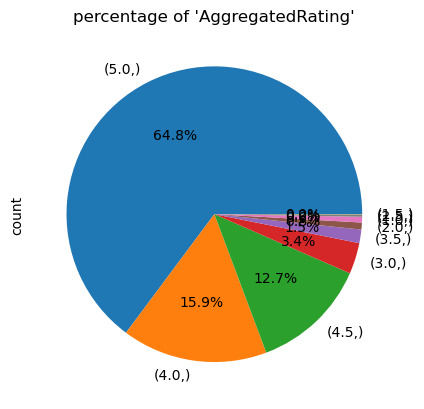

In [205]:
Recipe[["AggregatedRating"]].value_counts().plot(kind='pie', autopct='%0.1f%%', title="percentage of 'AggregatedRating'")


- it`s look like most of food are delicious 😋😋

<Axes: title={'center': "percentage of 'ReviewCount'"}, ylabel='count'>

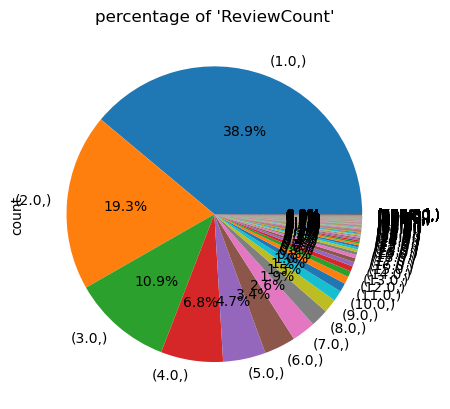

In [207]:
Recipe[["ReviewCount"]].value_counts().plot(kind='pie', autopct='%0.1f%%', title="percentage of 'ReviewCount'")


- most of user review only one time

In [209]:
num.remove("AuthorId")

<Axes: >

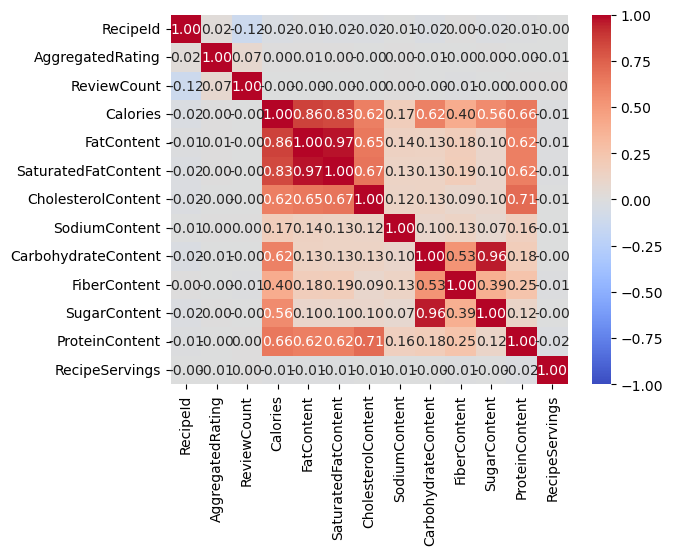

In [210]:
sns.heatmap(Recipe[num].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)  # Create the heatmap

## Food & Medical

In [212]:
df.columns

Index(['ReviewId', 'RecipeId', 'AuthorId_x', 'Rating', 'Review', 'Name',
       'AuthorId_y', 'Description', 'RecipeCategory', 'Keywords',
       'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions', 'num_rating'],
      dtype='object')

In [213]:
# Add new columns for each disease
df['HeartDisease'] = 0
df['Diabetes'] = 0
df['HighBloodPressure'] = 0
df['Obesity'] = 0
df['Hyperglycemia'] = 0
df['KidneyDisease'] = 0



df.loc[(df['Calories'] < 500) & 
       (df['FatContent'] < 20) & 
       (df['SaturatedFatContent'] < 5) & 
       (df['CholesterolContent'] < 150) & 
       (df['SodiumContent'] < 800) & 
       (df['FiberContent'] > 5) & 
       (df['ProteinContent'] < 25), 'HeartDisease'] = 1

df.loc[(df['Calories'] < 300) & 
       (df['SugarContent'] < 5) & 
       (df['CarbohydrateContent'] > 30) & 
       (df['FiberContent'] > 3) & 
       (df['FatContent'] < 10), 'Diabetes'] = 1

df.loc[(df['CholesterolContent'] < 200) & 
       (df['SodiumContent'] < 1500) & 
       (df['SaturatedFatContent'] < 7) & 
       (df['FiberContent'] > 5) & 
       (df['Calories'] < 400), 'HighBloodPressure'] = 1

df.loc[(df['Calories'] > 700) & 
       (df['FatContent'] > 30), 'Obesity'] = 1

df.loc[(df['SugarContent'] > 10) & 
       (df['CarbohydrateContent'] > 50), 'Hyperglycemia'] = 1

df.loc[(df['SodiumContent'] > 2000) & 
       (df['ProteinContent'] > 20), 'KidneyDisease'] = 1

In [214]:
df.columns

Index(['ReviewId', 'RecipeId', 'AuthorId_x', 'Rating', 'Review', 'Name',
       'AuthorId_y', 'Description', 'RecipeCategory', 'Keywords',
       'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions', 'num_rating',
       'HeartDisease', 'Diabetes', 'HighBloodPressure', 'Obesity',
       'Hyperglycemia', 'KidneyDisease'],
      dtype='object')

In [215]:
df['Hyperglycemia'].value_counts()

Hyperglycemia
0    117037
1     17873
Name: count, dtype: int64

In [216]:
df.head(5)

,ReviewId,RecipeId,AuthorId_x,Rating,Review,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,num_rating,HeartDisease,Diabetes,HighBloodPressure,Obesity,Hyperglycemia,KidneyDisease
0,335,12134,2695,5,This dish was excellent. The sauce turned out...,Pork Chops in Onion Sauce (Schweinekotelett in...,13483,Make and share this Pork Chops in Onion Sauce ...,Pork,"c(""Meat"", ""< 60 Mins"", ""Oven"", ""Stove Top"", ""E...","c(""4"", NA, ""1 1/2"", ""1 1/2"", ""2"", ""1/2"", ""1/2""...","c(""flour"", ""onions"", ""onions"", ""beer"", ""beef b...",5.0,112.0,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6,4.0,NaN,"c(""Season chops with salt and pepper; coat wit...",69,0,0,0,0,0,0
1,700,2886,2312,5,I used one more banana than called for because...,Best Banana Bread,1762,Make and share this Best Banana Bread recipe f...,Quick Breads,"c(""Breads"", ""Fruit"", ""Oven"", ""< 4 Hours"")","c(""1/2"", ""1"", ""2"", ""3"", ""1 1/2"", ""1"", ""1/2"", ""...","c(""butter"", ""granulated sugar"", ""eggs"", ""banan...",5.0,2273.0,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,1 loaf,"c(""Remove odd pots and pans from oven."", ""Preh...",150,0,0,0,0,0,0
2,829,8782,7802,4,"The recipe was easy to prepare, though a bit m...","Roast ""Sticky"" Chicken",6411,"Beautiful and delicious, this incredibly moist...",Whole Chicken,"c(""Chicken"", ""Poultry"", ""Meat"", ""Weeknight"", ""...","c(""4"", ""2"", ""1"", ""1"", ""1"", ""1"", ""1/2"", ""1/2"", ...","c(""salt"", ""paprika"", ""cayenne pepper"", ""onion ...",5.0,332.0,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6,6.0,2 Servings per Lb,"c(""(Day 1) Blend all spices together and set a...",187,0,0,0,0,0,0
3,1179,8754,9869,4,"just got these out of the oven, really nice, j...",Sweet Peanut Butter Cookies,7673,Make and share this Sweet Peanut Butter Cookie...,Dessert,"c(""Cookie & Brownie"", ""< 60 Mins"", ""For Large ...","c(""3/4"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""1/2"", ""1 1...","c(""peanut butter"", ""butter"", ""margarine"", ""bro...",5.0,126.0,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1,24.0,NaN,"c(""In medium mixing bowl beat together peanut ...",44,0,0,0,0,0,0
4,1257,9370,9121,5,I don't understand people who rate recipes wit...,Human Puppy Chow,10699,This is the best recipe in the world!! It is g...,Candy,"c(""Dessert"", ""Lunch/Snacks"", ""Toddler Friendly...","c(""1/2"", ""2"", ""1/3"", ""9"", ""4"")","c(""butter"", ""margarine"", ""peanut butter"", ""pow...",5.0,144.0,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1,NaN,9-10 cups,"c(""In a large sauce pan, melt together butter,...",57,0,0,0,0,1,0


In [217]:
df[df['Hyperglycemia']==1].sample(n=5)

,ReviewId,RecipeId,AuthorId_x,Rating,Review,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,num_rating,HeartDisease,Diabetes,HighBloodPressure,Obesity,Hyperglycemia,KidneyDisease
99374,984843,241166,599450,5,These are the best oatmeal chocolate chip cook...,Yummy Oatmeal Chocolate Chip Cookies,482376,A friend brought these to a picnic. After one ...,Drop Cookies,"c(""Dessert"", ""Cookie & Brownie"", ""Grains"", ""Po...","c(""2"", ""2"", ""2"", ""4"", ""2"", ""4"", ""5"", ""1"", ""2"",...","c(""butter"", ""sugar"", ""brown sugar"", ""eggs"", ""v...",5.0,74.0,483.3,23.0,13.5,57.3,311.9,69.1,3.6,44.3,5.8,30.0,"5 dozen, approx.","c(""Preheat the oven to 375 degrees F."", ""Cream...",51,0,0,0,0,1,0
94721,922546,107072,203325,5,"Oh my gosh, this was AWESOME! I don't attempt...",Crispy Ginger Beef,62043,"If you like sweet, spicy, crispy Chinese food-...",Steak,"c(""Meat"", ""Chinese"", ""Asian"", ""Lactose Free"", ...","c(""1"", ""3/4"", ""1/2"", ""2"", ""1"", ""3"", ""1/4"", ""5""...","c(""cornstarch"", ""water"", ""eggs"", ""carrot"", ""gr...",5.0,194.0,944.9,30.7,10.4,340.2,1740.6,106.2,3.0,53.5,58.9,NaN,NaN,"c(""Place cornstarch in a large bowl."", ""Add wa...",91,0,0,0,1,1,0
70917,656028,32204,138429,5,I made these brownies and they were wonderful....,&quot;Whatever Floats Your Boat&quot; Brownies!,37305,"These are absolutely the chewiest, moistest, f...",Bar Cookie,"c(""Dessert"", ""Lunch/Snacks"", ""Cookie & Brownie...","c(""1/2"", ""1/2"", ""1"", ""2"", ""2"", ""1/2"", ""1/4"", ""...","c(""butter"", ""sugar"", ""eggs"", ""vanilla"", ""flour...",5.0,1284.0,390.7,20.0,10.2,40.3,189.3,52.0,3.4,40.4,6.1,16.0,NaN,"c(""Preheat oven to 350°F."", ""Grease an 8 inch ...",502,0,0,0,0,1,0
95481,932017,75061,962690,5,"I only use my ABM to mix, knead and rise the d...",Awesome Homemade Crusty Bread (Bread Machine),24386,Found this recipe on the internet and made it ...,Yeast Breads,"c(""Breads"", ""Vegan"", ""Low Cholesterol"", ""Healt...","c(""1"", ""1"", ""2"", ""2"", ""1"", ""2 1/2"")","c(""warm water"", ""active dry yeast"", ""shortenin...",5.0,127.0,989.8,19.5,4.6,0.0,1561.8,177.8,6.9,17.3,23.5,NaN,1 1/2 lb loaf,"c(""Place ingredients in bread machine in the o...",62,0,0,0,0,1,0
10943,111821,92016,1535,5,Very good. I made it as a coffeecake (9-inch s...,Cinnamon Swirl Quick Bread,37036,This rich quick bread is a favorite with my fa...,Quick Breads,"c(""Breads"", ""Healthy"", ""Sweet"", ""Brunch"", ""< 6...","c(""1/4"", ""1 1/3"", ""1"", ""2"", ""1"", ""1/2"", ""1/2"",...","c(""butter"", ""sugar"", ""egg"", ""all-purpose flour...",5.0,179.0,2539.8,55.5,32.5,317.8,2897.0,476.9,10.9,278.9,41.0,NaN,1 loaf,"c(""Preheat oven to 350°F."", ""In a large mixing...",110,0,0,0,1,1,1


 ## Apply preprocessing

In [219]:
def basic_info(df):
    print("\n--- Dataset Info ---")
    print(df.info())
    print("\n--- Summary Statistics ---")
    print(df.describe())
basic_info(df)


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134910 entries, 0 to 134909
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ReviewId                    134910 non-null  int64  
 1   RecipeId                    134910 non-null  int64  
 2   AuthorId_x                  134910 non-null  int64  
 3   Rating                      134910 non-null  int64  
 4   Review                      134909 non-null  object 
 5   Name                        134910 non-null  object 
 6   AuthorId_y                  134910 non-null  int64  
 7   Description                 134910 non-null  object 
 8   RecipeCategory              134910 non-null  object 
 9   Keywords                    134243 non-null  object 
 10  RecipeIngredientQuantities  134910 non-null  object 
 11  RecipeIngredientParts       134910 non-null  object 
 12  AggregatedRating            134910 non-null  float


--- Missing Values Count ---
ReviewId                          0
RecipeId                          0
AuthorId_x                        0
Rating                            0
Review                            1
Name                              0
AuthorId_y                        0
Description                       0
RecipeCategory                    0
Keywords                        667
RecipeIngredientQuantities        0
RecipeIngredientParts             0
AggregatedRating                  0
ReviewCount                       0
Calories                          0
FatContent                        0
SaturatedFatContent               0
CholesterolContent                0
SodiumContent                     0
CarbohydrateContent               0
FiberContent                      0
SugarContent                      0
ProteinContent                    0
RecipeServings                52977
RecipeYield                   94649
RecipeInstructions                0
num_rating                        

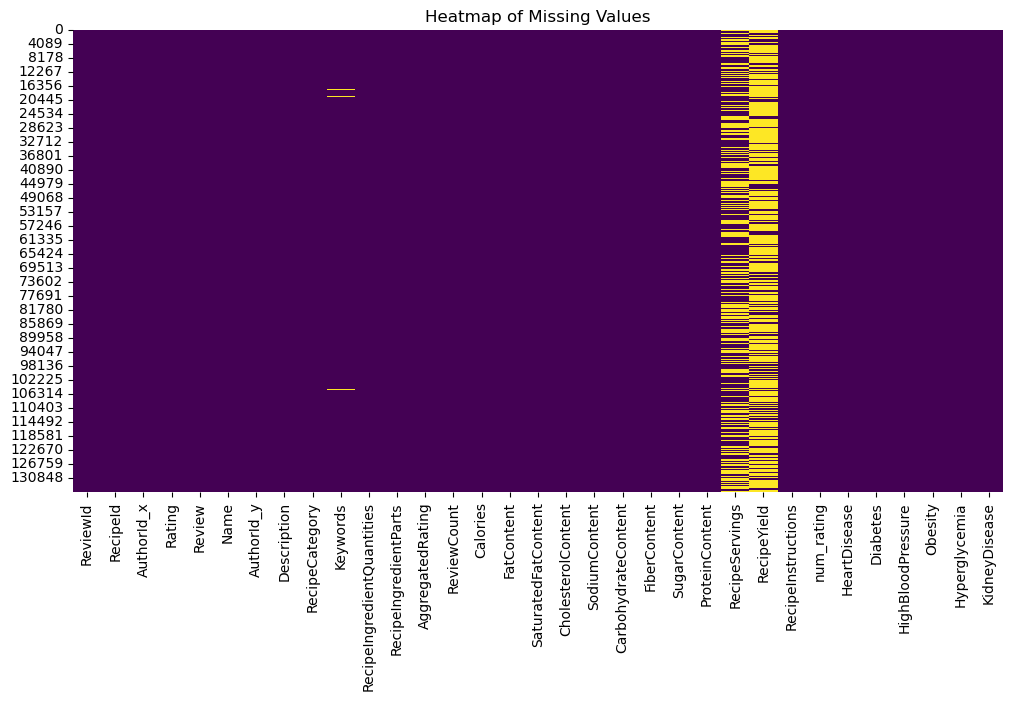

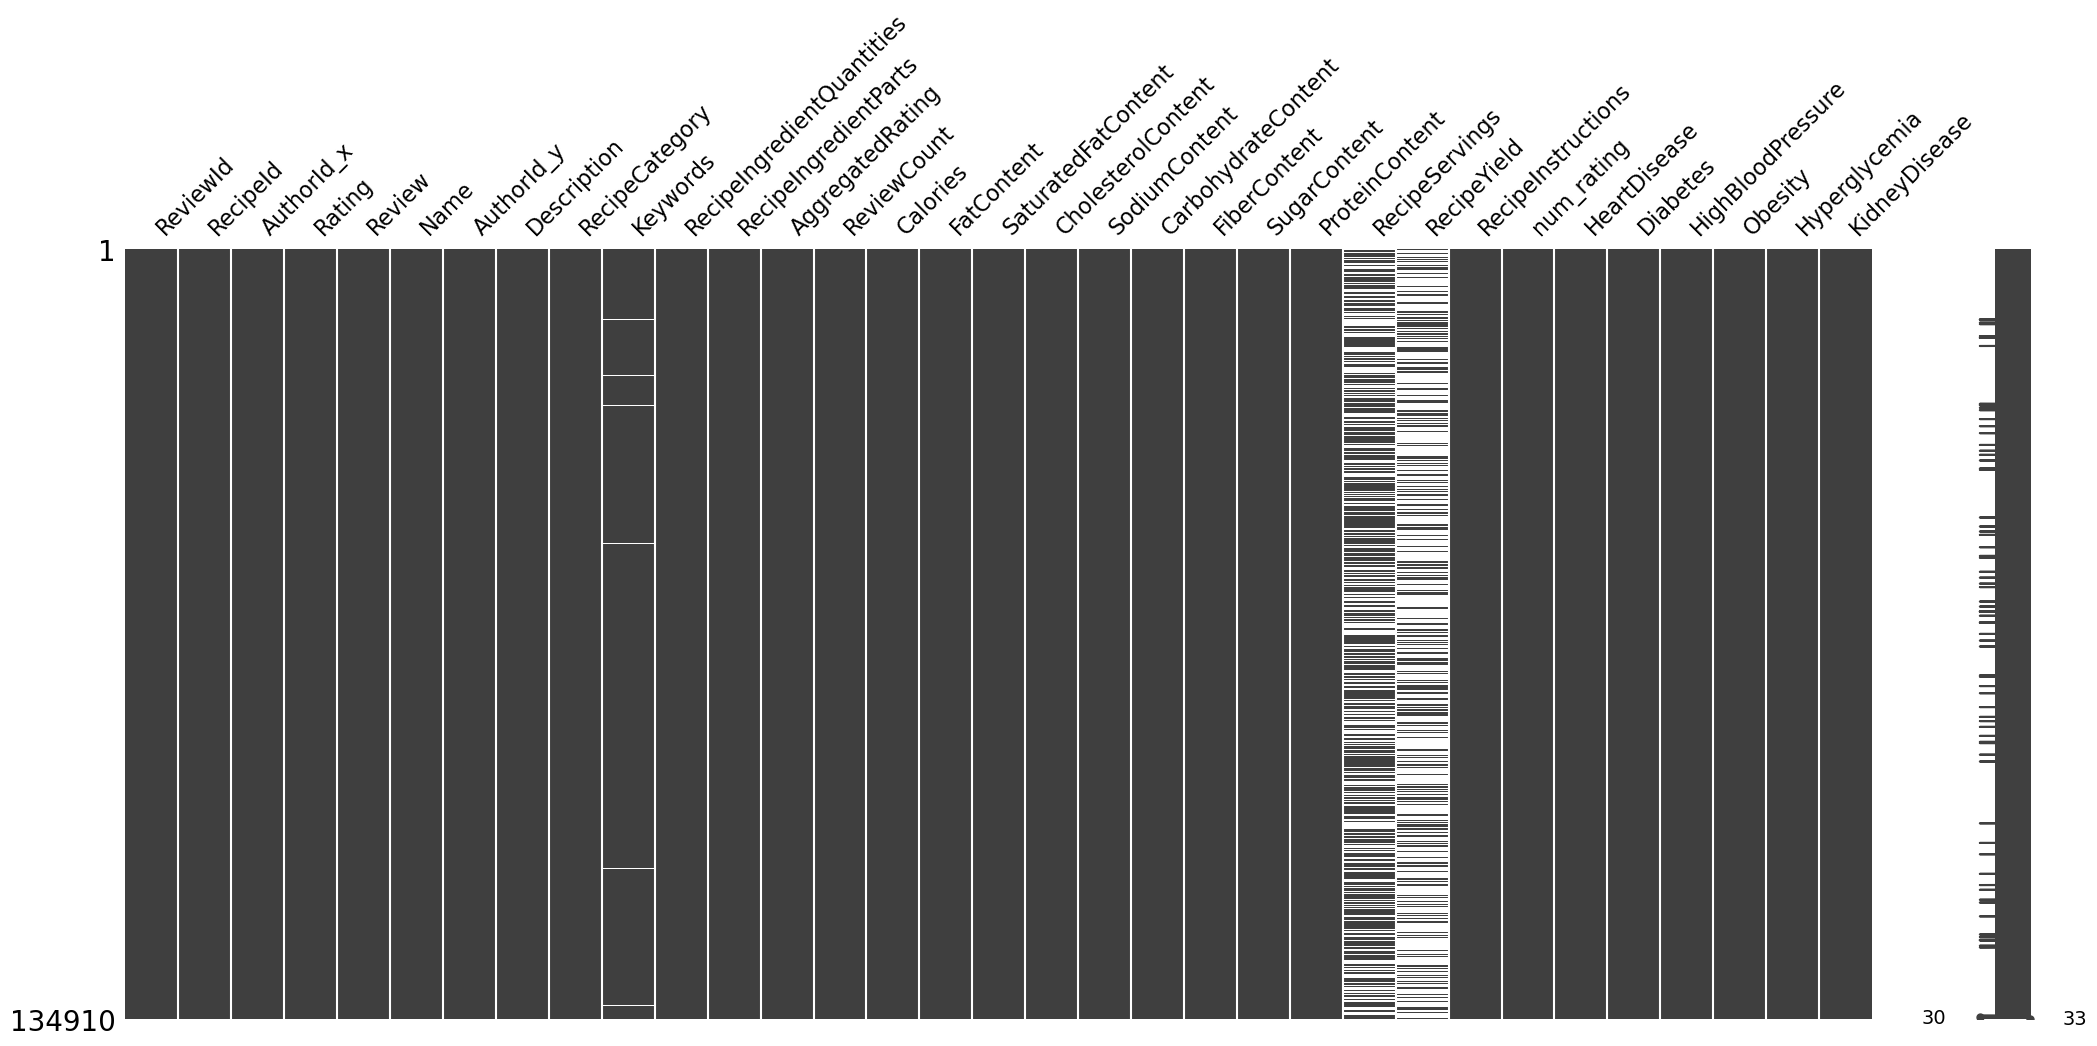

In [220]:
def missing_values_analysis(df):
    print("\n--- Missing Values Count ---")
    print(df.isnull().sum())
    # Visualizing missing data
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Values')
    plt.show()
    
    # Another visual representation
    msno.matrix(df)
    plt.show()
missing_values_analysis(df)

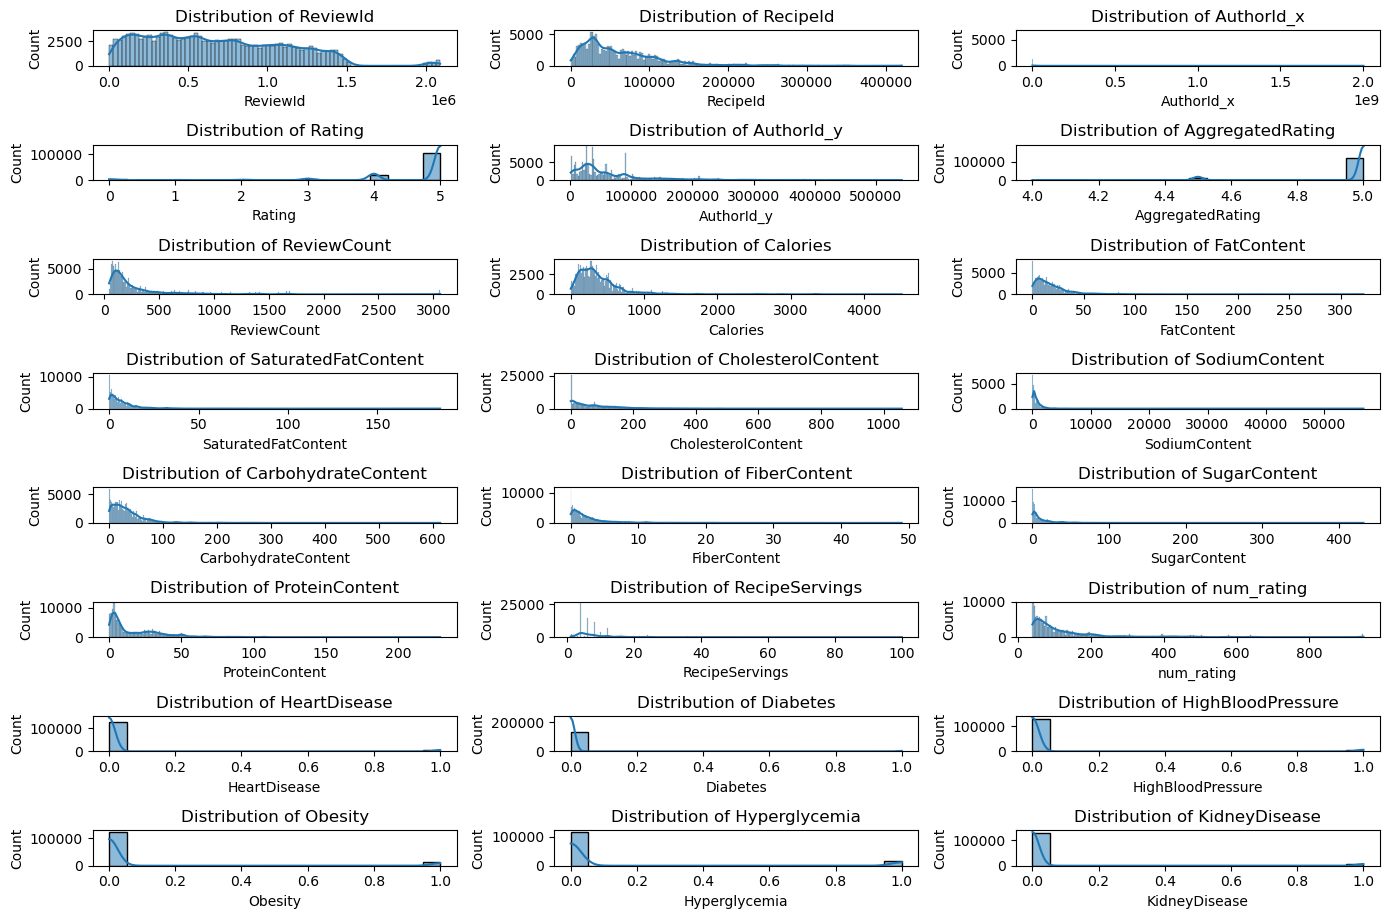

In [221]:
def numerical_distribution(df):
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(14, 10))
    for i, col in enumerate(num_columns, 1):
        plt.subplot(len(num_columns) // 3 + 1, 3, i)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
numerical_distribution(df)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3054480059.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[col], palette="Set3")
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3054480059.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[col], palette="Set3")
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3054480059.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[col], palette="Set3")
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3054480059.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is depr

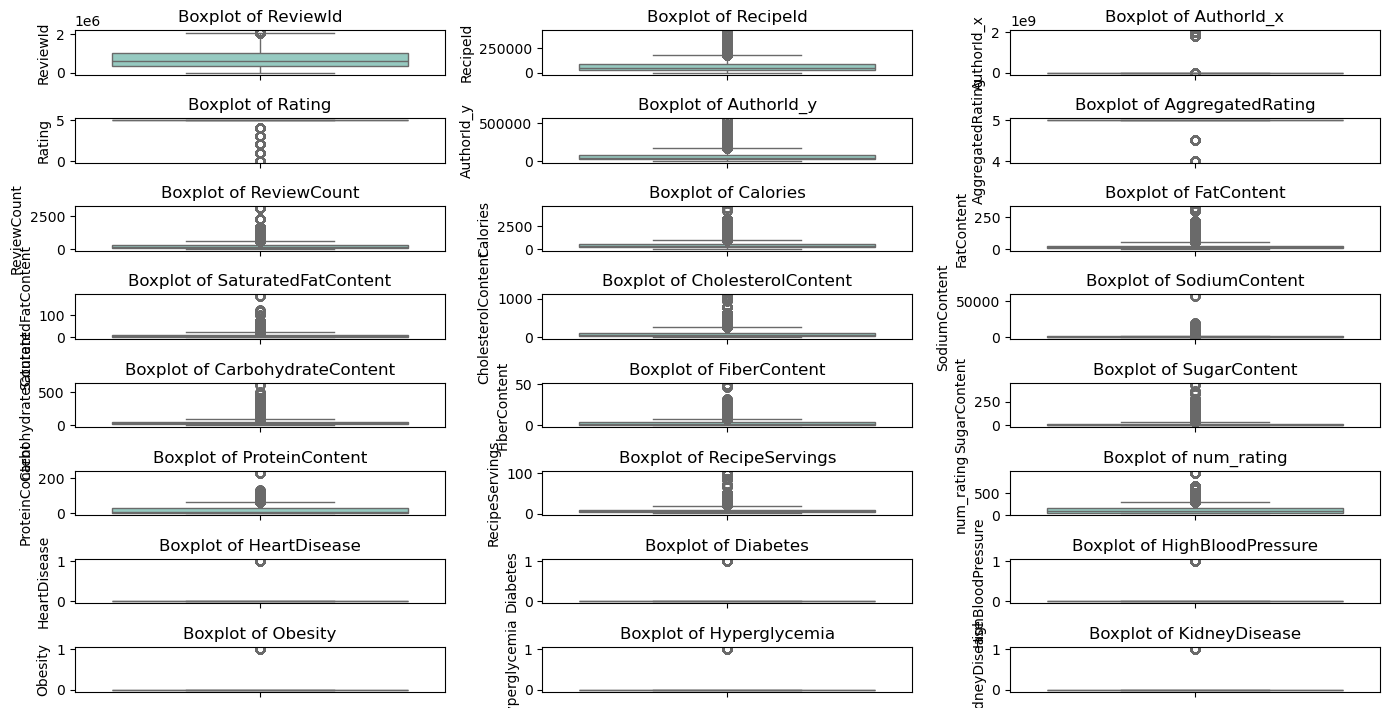

In [222]:
def outlier_detection(df):
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(num_columns, 1):
        plt.subplot(len(num_columns) // 3 + 1, 3, i)
        sns.boxplot(df[col], palette="Set3")
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
outlier_detection(df)

In [223]:
df.duplicated().sum()

0

In [224]:
missing_percent = df.isnull().mean()
    
# Drop columns with too many missing values
columns_to_drop = missing_percent[missing_percent > .4].index
df = df.drop(columns=columns_to_drop)
    
# Impute remaining missing values
for col in df.columns:
   if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
   else:
       df[col].fillna(df[col].mode()[0], inplace=True)
df.isnull().sum()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3043179028.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12968\3043179028.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

ReviewId                      0
RecipeId                      0
AuthorId_x                    0
Rating                        0
Review                        0
Name                          0
AuthorId_y                    0
Description                   0
RecipeCategory                0
Keywords                      0
RecipeIngredientQuantities    0
RecipeIngredientParts         0
AggregatedRating              0
ReviewCount                   0
Calories                      0
FatContent                    0
SaturatedFatContent           0
CholesterolContent            0
SodiumContent                 0
CarbohydrateContent           0
FiberContent                  0
SugarContent                  0
ProteinContent                0
RecipeServings                0
RecipeInstructions            0
num_rating                    0
HeartDisease                  0
Diabetes                      0
HighBloodPressure             0
Obesity                       0
Hyperglycemia                 0
KidneyDi

In [225]:
df

,ReviewId,RecipeId,AuthorId_x,Rating,Review,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,num_rating,HeartDisease,Diabetes,HighBloodPressure,Obesity,Hyperglycemia,KidneyDisease
0,335,12134,2695,5,This dish was excellent. The sauce turned out...,Pork Chops in Onion Sauce (Schweinekotelett in...,13483,Make and share this Pork Chops in Onion Sauce ...,Pork,"c(""Meat"", ""< 60 Mins"", ""Oven"", ""Stove Top"", ""E...","c(""4"", NA, ""1 1/2"", ""1 1/2"", ""2"", ""1/2"", ""1/2""...","c(""flour"", ""onions"", ""onions"", ""beer"", ""beef b...",5.0,112.0,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6,4.0,"c(""Season chops with salt and pepper; coat wit...",69,0,0,0,0,0,0
1,700,2886,2312,5,I used one more banana than called for because...,Best Banana Bread,1762,Make and share this Best Banana Bread recipe f...,Quick Breads,"c(""Breads"", ""Fruit"", ""Oven"", ""< 4 Hours"")","c(""1/2"", ""1"", ""2"", ""3"", ""1 1/2"", ""1"", ""1/2"", ""...","c(""butter"", ""granulated sugar"", ""eggs"", ""banan...",5.0,2273.0,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,"c(""Remove odd pots and pans from oven."", ""Preh...",150,0,0,0,0,0,0
2,829,8782,7802,4,"The recipe was easy to prepare, though a bit m...","Roast ""Sticky"" Chicken",6411,"Beautiful and delicious, this incredibly moist...",Whole Chicken,"c(""Chicken"", ""Poultry"", ""Meat"", ""Weeknight"", ""...","c(""4"", ""2"", ""1"", ""1"", ""1"", ""1"", ""1/2"", ""1/2"", ...","c(""salt"", ""paprika"", ""cayenne pepper"", ""onion ...",5.0,332.0,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6,6.0,"c(""(Day 1) Blend all spices together and set a...",187,0,0,0,0,0,0
3,1179,8754,9869,4,"just got these out of the oven, really nice, j...",Sweet Peanut Butter Cookies,7673,Make and share this Sweet Peanut Butter Cookie...,Dessert,"c(""Cookie & Brownie"", ""< 60 Mins"", ""For Large ...","c(""3/4"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""1/2"", ""1 1...","c(""peanut butter"", ""butter"", ""margarine"", ""bro...",5.0,126.0,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1,24.0,"c(""In medium mixing bowl beat together peanut ...",44,0,0,0,0,0,0
4,1257,9370,9121,5,I don't understand people who rate recipes wit...,Human Puppy Chow,10699,This is the best recipe in the world!! It is g...,Candy,"c(""Dessert"", ""Lunch/Snacks"", ""Toddler Friendly...","c(""1/2"", ""2"", ""1/3"", ""9"", ""4"")","c(""butter"", ""margarine"", ""peanut butter"", ""pow...",5.0,144.0,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1,6.0,"c(""In a large sauce pan, melt together butter,...",57,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134905,2090182,31235,1736962,5,I make this all of the time and it is deliciou...,Crunchy Granola,35701,"This granola makes a GREAT, filling snack. Goo...",Breakfast,"c(""Lunch/Snacks"", ""Grains"", ""Fruit"", ""Nuts"", ""...","c(""1 1/2"", ""1/2"", ""4"", ""1"", ""8"", ""1"", ""1"", NA)","c(""brown sugar"", ""water"", ""pure vanilla extrac...",5.0,149.0,533.3,19.2,1.9,0.0,293.0,80.9,9.1,34.0,12.5,10.0,"c(""Heat oven to 275 degrees F."", ""Line 2 cooki...",88,0,0,0,0,1,0
134906,2090251,49088,2038463,5,This will definitely be a repeat in my recipe ...,Mexican Casserole,64224,Make and share this Mexican Casserole recipe f...,One Dish Meal,"c(""Meat"", ""Mexican"", ""< 60 Mins"", ""Oven"", ""Ine...","c(""2"", ""1/2"", ""1"", ""1"", ""1"", ""1"", ""1"", ""3"", ""1"")","c(""hamburger meat"", ""onion"", ""green chilies"", ...",5.0,115.0,709.8,38.7,17.4,121.6,1940.8,50.0,3.9,8.1,39.0,8.0,"c(""Brown hamburger meat with onion and taco se...",63,0,0,0,1,0,0
134907,2090259,43023,894666,5,Just got a homemade pasta machine as a gift an...,Creamy Garlic Penne Pasta,37305,"This is a delicious, sup

In [226]:
df.columns

Index(['ReviewId', 'RecipeId', 'AuthorId_x', 'Rating', 'Review', 'Name',
       'AuthorId_y', 'Description', 'RecipeCategory', 'Keywords',
       'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeInstructions', 'num_rating', 'HeartDisease',
       'Diabetes', 'HighBloodPressure', 'Obesity', 'Hyperglycemia',
       'KidneyDisease'],
      dtype='object')

## Recommendation Algorithms

 ## Collaborative Filtering: the system is expected rating for the user on the recipe

In [229]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split  # Import from surprise
from surprise import SVD
from surprise import accuracy
import pandas as pd

# 1. Prepare the data for Surprise
# Load your data into a pandas DataFrame (make sure df is defined)
  # Ensure your CSV file path is correct
reader = Reader(rating_scale=(1, 5))  # Define the rating scale from 1 to 5.
surprise_data = Dataset.load_from_df(df[['AuthorId_x', 'RecipeId', 'Rating']], reader)

# 2. Split the data into training and testing sets using Surprise's method
trainset, testset = train_test_split(surprise_data, test_size=0.2,random_state=42)

# 3. Build the SVD model
model = SVD()  # Instantiate the SVD (Singular Value Decomposition) model for collaborative filtering.

# 4. Train the model
model.fit(trainset)  # Fit the SVD model on the training data.

# 5. Test the model and evaluate its performance
predictions = model.test(testset)  # Generate predictions for the test set.

# Evaluate performance using RMSE (Root Mean Squared Error)
rmse_score = accuracy.rmse(predictions)  # Calculate RMSE to measure prediction accuracy.
print(f"RMSE: {rmse_score}")  # Print the RMSE score.

# 6. Provide recommendations for a specific user
# Predict the rating for a specific recipe by a specific user
user_id = 78897  # Replace with the actual user ID you want to test.
recipe_id = 824654  # Replace with the actual recipe ID you want to evaluate.
predicted_rating = model.predict(user_id, recipe_id)  # Use the model to predict the rating.

# Print the expected rating for the user on the recipe
print(f"The predicted rating for user {user_id} on recipe {recipe_id} is: {predicted_rating.est:.2f}")  # Display the predicted rating, formatted to two decimal places.


RMSE: 0.8818
RMSE: 0.8817518234380836
The predicted rating for user 78897 on recipe 824654 is: 4.64


## Collaborative Filtering : The system will recommend similar recipes to users based on their past ratings

In [231]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# تحميل البيانات

# الخطوة 1: معالجة البيانات
# إنشاء جدول محوري يحتوي على المستخدمين (AuthorId_x) وتقييماتهم للوصفات (RecipeId) prerocessing
user_recipe_matrix = df.pivot_table(index='AuthorId_x', columns='RecipeId', values='Rating').fillna(0)

# الخطوة 2: التصفية التعاونية (Cosine Similarity)
# حساب التشابه بين الوصفات بناءً على تقييمات المستخدمين
recipe_similarity = cosine_similarity(user_recipe_matrix.T)
recipe_similarity_df = pd.DataFrame(recipe_similarity, index=user_recipe_matrix.columns, columns=user_recipe_matrix.columns)

# الخطوة 3: اقتراح وصفات مشابهة
def recommend_recipes(user_id, n_recommendations=5, health_conditions=None):
    # جلب تقييمات المستخدم
    user_ratings = user_recipe_matrix.loc[user_id]
    
    # فلترة الوصفات التي قام المستخدم بتقييمها بشكل إيجابي (تقييمات >= 4)
    liked_recipes = user_ratings[user_ratings >= 4].index.tolist()
    
    # قائمة لحفظ الوصفات المقترحة
    recommendations = pd.Series(dtype=float)
    print(recommendations)

    
    
    # المرور على كل وصفة محببة واستخراج الوصفات المشابهة
    for recipe_id in liked_recipes:
        # جلب درجات التشابه للوصفة
        similar_recipes = recipe_similarity_df[recipe_id].sort_values(ascending=False)
        
        # إزالة الوصفات التي قام المستخدم بتقييمها مسبقاً
        similar_recipes = similar_recipes[~similar_recipes.index.isin(liked_recipes)]
        
        # دمج الوصفات المشابهة مع التوصيات باستخدام pd.concat
        recommendations = pd.concat([recommendations, similar_recipes])
    
    # ترتيب الوصفات حسب درجة التشابه
    recommendations = recommendations.groupby(recommendations.index).mean().sort_values(ascending=False)
    
    # فلترة التوصيات بناءً على الحالات الصحية إذا تم توفيرها
    if health_conditions:
        for condition in health_conditions:
            # هنا نتاكد من أن القيم مطابقة، وفلترة التوصيات المناسبة للحالة الصحية
            valid_recipes = df[df['RecipeId'].isin(recommendations.index) & (df[condition] == 0)]
            recommendations = recommendations[recommendations.index.isin(valid_recipes['RecipeId'])]
    
    # إرجاع أفضل N توصية
    return df[df['RecipeId'].isin(recommendations.head(n_recommendations).index)][['RecipeId', 'Name', 'RecipeCategory', 'Calories']]

# الخطوة 4: مثال للاستخدام
# رقم المستخدم = 678366 (مثال)، فلترة للوصفات المناسبة لأمراض القلب
user_id = 678366
health_conditions = ['HeartDisease', 'Diabetes']

recommended_recipes = recommend_recipes(user_id, n_recommendations=5, health_conditions=health_conditions)
print(recommended_recipes)


Series([], dtype: float64)
        RecipeId                             Name  RecipeCategory  Calories
716        28148  Oven-Fried Chicken Chimichangas   One Dish Meal     353.9
1810       35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
1917       35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
2105       35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
2234       35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
...          ...                              ...             ...       ...
134296     45809                  Bourbon Chicken  Chicken Breast     521.4
134424     35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
134536     35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
134591     35813           Oatmeal Raisin Cookies    Drop Cookies     188.6
134818     45809                  Bourbon Chicken  Chicken Breast     521.4

[2291 rows x 4 columns]


 ##  Collaborative filtering: This method recommends recipes to users based on their rating patterns in comparison with similar users.

In [233]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy


# Filter the necessary columns for collaborative filtering
df_filtered = df[['AuthorId_x', 'RecipeId', 'Rating']]

# Prepare the data for the Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filtered, reader)

# Split the data into training and testing sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

# Use KNNBasic for collaborative filtering (user-based)
algo = KNNBasic(sim_options={'user_based': True})

# Train the model
algo.fit(trainset)

# Test the model on the testset
predictions = algo.test(testset)

# Evaluate model performance (using RMSE)
rmse = accuracy.rmse(predictions)

# Output the RMSE score
print(f"RMSE: {rmse}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9081
RMSE: 0.9081293827394818


###  Content-based recommendation code: tailored to your project. This code filters recipes based on the user's health conditions, maximum calorie intake, and allergies.

In [235]:

# Function to filter recipes based on user health conditions, calorie limit, and allergies
def filter_recipes(df, health_conditions, max_calories, allergies):
    """
    Filters recipes based on health conditions, calorie limit, and allergies.
    
    Parameters:
        df (pd.DataFrame): The dataset containing recipe details.
        health_conditions (list): List of health conditions to consider (e.g., ['HeartDisease', 'Diabetes']).
        max_calories (int): The maximum allowed calorie count for a recipe.
        allergies (list): List of ingredients to avoid (e.g., ['nuts', 'milk']).
        
    Returns:
        pd.DataFrame: Filtered DataFrame with suitable recipes.
    """
    # Filter based on health conditions
    for condition in health_conditions:
        df = df[df[condition] == 0]  # Only include recipes safe for the user's conditions

    # Filter based on calorie limit
    df = df[df['Calories'] <= max_calories]
    
    # Filter based on allergies
    if allergies:
        df = df[~df['RecipeIngredientParts'].str.contains('|'.join(allergies), case=False, na=False)]
    
    return df


# Example input parameters
health_conditions = ['HeartDisease', 'Diabetes']  # User's health conditions
max_calories = 50  # User's maximum calorie intake
allergies = [ 'Dairy ','Nuts ','Shellfish ','Soy ','nuts', 'milk', 'eggs']  # Ingredients the user is allergic to

# Apply filtering
filtered_recipes = filter_recipes(df, health_conditions, max_calories, allergies)

# Show the filtered recipes
print(filtered_recipes[['Name', 'Calories', 'RecipeIngredientParts']])


                                                     Name  Calories  \
32                                        Wonderful Salsa      12.5   
38                                        Wonderful Salsa      12.5   
120                                       Wonderful Salsa      12.5   
124                        Roast Beef Horseradish Spirals      42.0   
144                        Roast Beef Horseradish Spirals      42.0   
...                                                   ...       ...   
134749  Taco Seasoning - Budget Friendly Seasoning for...      48.3   
134765     Kittencal's Low-Fat Oven-Baked Zucchini Sticks       8.6   
134770                                 Taco Seasoning Mix      29.0   
134771                               Taco Bell Taco Sauce      23.8   
134908                          Perfectly Juice Prime Rib      17.2   

                                    RecipeIngredientParts  
32      c("tomatoes", "onions", "green peppers", "garl...  
38      c("tomatoes", "onio

## After filtering the recipes, you can Evaluate the recommendations using feedback data and metrics like Precision, Recall, and F1-Score. Here's an outline

In [237]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have actual feedback (1 = relevant, 0 = irrelevant)
# For example: y_true = [1, 0, 1, 1, 0] for 5 recommended recipes
# y_pred = [1, 0, 1, 0, 0] based on the system's recommendations

def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

# Example usage:
# precision, recall, f1 = evaluate_model(y_true, y_pred)
# print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


## Apply Diet recomendation system

In [239]:
selected_columns = ['RecipeId', 'Calories', 'FatContent', 'SaturatedFatContent',
                     'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                     'FiberContent', 'SugarContent', 'ProteinContent']

# Apply the selected columns to the DataFrame
Diet = df[selected_columns]

# Display the first few rows of the updated DataFrame
Diet.head()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,12134,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6
1,2886,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7
2,8782,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6
3,8754,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1
4,9370,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1


In [240]:
Diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134910 entries, 0 to 134909
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   RecipeId             134910 non-null  int64  
 1   Calories             134910 non-null  float64
 2   FatContent           134910 non-null  float64
 3   SaturatedFatContent  134910 non-null  float64
 4   CholesterolContent   134910 non-null  float64
 5   SodiumContent        134910 non-null  float64
 6   CarbohydrateContent  134910 non-null  float64
 7   FiberContent         134910 non-null  float64
 8   SugarContent         134910 non-null  float64
 9   ProteinContent       134910 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 10.3 MB


In [241]:
# Define the columns to filter based on the 95th percentile
filter_columns = ['Calories', 'FatContent', 'SaturatedFatContent',
                   'CholesterolContent', 'SodiumContent',
                   'CarbohydrateContent', 'FiberContent',
                   'SugarContent', 'ProteinContent']

# Compute the 95th percentile values for each specified column
percentile_95_thresholds = df[filter_columns].quantile(0.95)

# Display the 95th percentile thresholds for each column
percentile_95_thresholds

Calories               1006.6
FatContent               56.6
SaturatedFatContent      24.1
CholesterolContent      238.8
SodiumContent          2250.2
CarbohydrateContent      92.0
FiberContent              9.1
SugarContent             49.8
ProteinContent           52.4
Name: 0.95, dtype: float64

In [242]:
Diet.describe()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
count,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000,134910.000000
mean,64443.721110,392.996137,19.909948,7.883307,77.688274,788.895894,36.180601,2.696265,13.681616,17.900347
std,53789.823086,371.352207,25.621022,11.334881,97.829569,1822.509157,45.045081,3.797892,26.543025,20.052966
min,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26557.000000,176.800000,6.400000,1.900000,12.400000,192.900000,12.700000,0.600000,2.000000,3.600000
50%,50124.000000,307.100000,13.800000,5.000000,48.900000,435.500000,26.100000,1.500000,5.200000,8.700000
75%,88437.000000,496.800000,24.900000,10.200000,113.300000,912.100000,46.100000,3.200000,15.700000,28.100000
max,420398.000000,4518.400000,322.200000,185.100000,1058.300000,56688.400000,613.900000,49.000000,431.900000,229.000000


In [243]:
# Apply filtering to the DataFrame based on the 95th percentile values
filtered_df = Diet[(Diet[filter_columns] <= percentile_95_thresholds).all(axis=1)]

# Print the filtered DataFrame
print(filtered_df)

        RecipeId  Calories  FatContent  SaturatedFatContent  \
0          12134     438.5        23.2                  6.7   
1           2886     272.8        10.5                  6.2   
2           8782     238.0        15.7                  4.5   
3           8754     146.5         8.2                  3.4   
5           9841     346.0        13.7                  8.3   
...          ...       ...         ...                  ...   
134904    261889     144.2         5.7                  3.5   
134905     31235     533.3        19.2                  1.9   
134906     49088     709.8        38.7                 17.4   
134907     43023     363.8         8.3                  4.4   
134909     26370     477.9        28.2                  8.2   

        CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  \
0                    137.3          224.7                 10.3           1.0   
1                     61.6          338.3                 42.5           1.4   
2  

In [244]:
Diet.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T


,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
RecipeId,134910.0,64443.721110,53789.823086,56.0,9272.0,13630.00,26557.0,50124.0,88437.0,131018.0,158832.0,420398.0
Calories,134910.0,392.996137,371.352207,0.0,64.3,98.40,176.8,307.1,496.8,716.7,1006.6,4518.4
FatContent,134910.0,19.909948,25.621022,0.0,0.6,2.50,6.4,13.8,24.9,40.3,56.6,322.2
SaturatedFatContent,134910.0,7.883307,11.334881,0.0,0.1,0.60,1.9,5.0,10.2,17.0,24.1,185.1
CholesterolContent,134910.0,77.688274,97.829569,0.0,0.0,0.00,12.4,48.9,113.3,179.3,238.8,1058.3
SodiumContent,134910.0,788.895894,1822.509157,0.0,27.2,72.82,192.9,435.5,912.1,1573.0,2250.2,56688.4
CarbohydrateContent,134910.0,36.180601,45.045081,0.0,1.7,3.60,12.7,26.1,46.1,72.5,92.0,613.9
FiberContent,134910.0,2.696265,3.797892,0.0,0.1,0.20,0.6,1.5,3.2,6.5,9.1,49.0
SugarContent,134910.0,13.681616,26.543025,0.0,0.2,0.40,2.0,5.2,15.7,35.8,49.8,431.9
ProteinContent,134910.0,17.900347,20.052966,0.0,0.8,1.60,3.6,8.7,28.1,44.0,52.4,229.0


In [245]:
selected_columns = ['RecipeId', 'Calories', 'FatContent', 'SaturatedFatContent',
                     'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                     'FiberContent', 'SugarContent', 'ProteinContent']

# Apply the selected columns to the DataFrame
Diet = df[selected_columns]

# Display the first few rows of the updated DataFrame
Diet.head()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,12134,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6
1,2886,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7
2,8782,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6
3,8754,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1
4,9370,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1


In [246]:
Diet = Diet.sample(3000)
Diet

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
67449,4957,71.4,1.6,0.4,36.3,239.3,0.7,0.2,0.3,12.7
47415,18387,1899.9,93.9,39.5,196.4,4934.1,183.5,15.0,16.3,80.5
27681,20616,211.6,6.7,3.6,38.2,263.4,33.9,1.3,11.4,4.6
9553,77497,165.8,2.0,0.4,0.0,264.6,32.4,3.4,6.9,5.4
36821,39900,483.5,24.1,9.6,162.0,732.9,24.6,1.2,1.3,40.1
...,...,...,...,...,...,...,...,...,...,...
113325,5031,268.1,5.6,1.2,0.0,18651.2,58.3,21.1,4.8,11.8
73025,12192,25.0,0.2,0.1,0.0,15.9,4.7,2.3,1.5,2.7
87076,80675,1087.3,114.7,68.9,333.6,1104.6,7.6,0.3,5.0,11.8
44536,25723,44.2,0.7,0.2,5.7,52.3,8.3,0.5,2.8,1.1


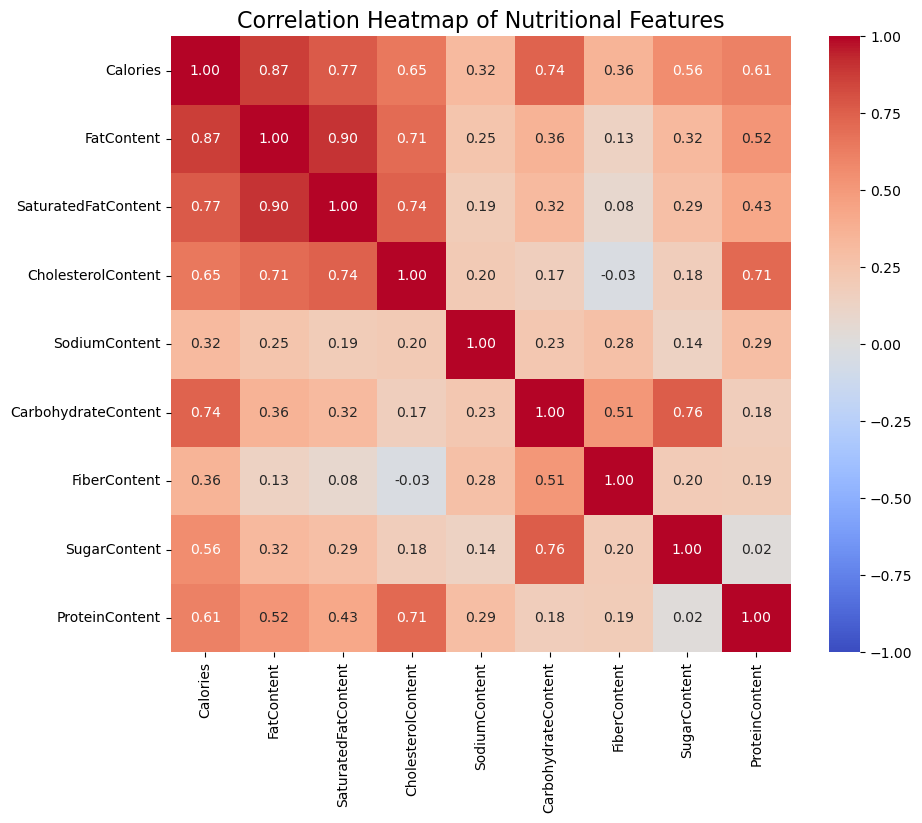

In [247]:
# Compute the correlation matrix for the nutritional features
# The 'RecipeId' column is dropped as it's not a numerical feature and does not contribute to the correlation calculation
corr = Diet.drop(columns=['RecipeId']).corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size for the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)  # Create the heatmap
# `annot=True` adds the correlation coefficients on the heatmap
# `cmap='coolwarm'` sets the color map to show the correlation values with a gradient from cool to warm
# `fmt='.2f'` formats the correlation values to two decimal places
# `vmin` and `vmax` set the color scale range for better visualization of correlations
plt.title('Correlation Heatmap of Nutritional Features', fontsize=16)  # Set the title of the heatmap
plt.show()  # Display the heatmap

In [248]:
X = Diet.drop(columns=['RecipeId'])

# Assign the 'RecipeId' column to y
y = Diet['RecipeId']

In [249]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to X and transform it
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [250]:
from sklearn.model_selection import train_test_split
X_train_scaled, X_eval_scaled = train_test_split(X_scaled, train_size=0.8, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training set shape:", X_train_scaled.shape)
print("Evaluation set shape:", X_eval_scaled.shape)

Training set shape: (2400, 9)
Evaluation set shape: (600, 9)


In [251]:
# Neural Network Model Architecture
num_features = X_train_scaled.shape[1]# Number of features in the input data
print(num_features)

# Define the autoencoder model
model = Sequential([
    # Encoder
    Dense(256, input_shape=(num_features,)),  # Input layer with 256 neurons
    LeakyReLU(),  # Activation function with a small slope for negative inputs
    Dropout(0.2),  # Dropout layer with 20% dropout rate to prevent overfitting

    Dense(128),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    Dense(64),  # Hidden layer with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    # Bottleneck
    Dense(32),  # Bottleneck layer with 32 neurons

    # Decoder
    Dense(64),  # Hidden layer in the decoder with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    Dense(128),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    Dense(256),  # Hidden layer with 256 neurons
    LeakyReLU(),  # Activation function

    # Output layer
    Dense(num_features, activation='linear')  # Output layer with linear activation
])
# Summary of the model to check the architecture
model.summary()

9


C:\Users\ahmed\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,561 (357.66 KB)

 Trainable params: 91,561 (357.66 KB)

 Non-trainable params: 0 (0.00 B)

In [252]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',  # Mean Squared Error for regression
              metrics=['mae'])  # Mean Absolute Error for regression evaluation

In [253]:
training_history = model.fit(X_train_scaled, X_train_scaled,
                             validation_data=(X_eval_scaled, X_eval_scaled),
                             epochs=40)

# Extract validation loss from the training history
validation_loss = training_history.history['val_loss']

Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0024 - val_mae: 0.0302
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - mae: 0.0306 - val_loss: 0.0015 - val_mae: 0.0231
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0261 - val_loss: 9.5863e-04 - val_mae: 0.0176
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0233 - val_loss: 6.6790e-04 - val_mae: 0.0152
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - mae: 0.0209 - val_loss: 5.7510e-04 - val_mae: 0.0142
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0200 - val_loss: 5.0907e-04 - val_mae: 0.0132
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0186 - val_loss: 4.8737e-04 - val_mae: 0.0127
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5239e-04 - mae: 0.0177 - val_loss: 3.8406e-04 - val_mae: 0.0113
Epoch 9/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [254]:
predicted_latent_features = model.predict(X_scaled)
predicted_latent_features
joblib.dump(model, "model.pkl")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


['model.pkl']

In [255]:
# Manual calculation of cosine similarity

# Compute the Dot Product:
# This calculates the dot product between each pair of latent feature vectors.
# The result is a matrix where each entry represents the dot product (or similarity) between two feature vectors.
similarity_matrix = np.dot(predicted_latent_features, predicted_latent_features.T)
# Calculate the Norms:
# The norm (or magnitude) of each latent feature vector is calculated.
# 'axis=1' indicates that the norm is computed for each row (each feature vector).
# 'keepdims=True' keeps the dimensions of the output the same for broadcasting purposes.
norms = np.linalg.norm(predicted_latent_features, axis=1, keepdims=True)
# Normalize the Similarity Matrix:
# Each entry in the similarity matrix is divided by the product of the norms of the vectors being compared.
# This normalizes the similarity scores to cosine similarity, which ranges from -1 to 1.
similarity_matrix /= np.dot(norms, norms.T)

# Print the shape of the similarity matrix to confirm dimensions
print(similarity_matrix)

[[1.         0.7165781  0.55473423 ... 0.6331283  0.39281577 0.32709208]
 [0.7165781  0.9999999  0.9323296  ... 0.74414915 0.8399871  0.68993354]
 [0.55473423 0.9323296  0.99999994 ... 0.688442   0.8617327  0.65696084]
 ...
 [0.6331283  0.74414915 0.688442   ... 0.99999994 0.48972085 0.23334709]
 [0.39281577 0.8399871  0.8617327  ... 0.48972085 1.0000001  0.85831875]
 [0.32709208 0.68993354 0.65696084 ... 0.23334709 0.85831875 1.        ]]


In [256]:
# Initialize a dictionary to store recommendations
top_n = 100 

recommendations_dict = {}

# Iterate over each item in the dataset
for item_index in range(len(X_scaled)):
    # Sort indices based on similarity in descending order
    sorted_indices = similarity_matrix[item_index].argsort()[::-1][:top_n]

    # Create a list of tuples with similarity scores and indices, excluding the item itself
    similar_items_list = [(similarity_matrix[item_index][idx], idx) for idx in sorted_indices]

    # Store the list of similar items for the current item in the recommendations dictionary
    recommendations_dict[item_index] = similar_items_list
joblib.dump(recommendations_dict, "recommendations_compressed.pkl", compress=True)

['recommendations_compressed.pkl']

In [257]:
# Define the number of items to display from the recommendations
# items_to_display = 10

# # Iterate through the first 'items_to_display' entries in the recommendations dictionary
# for index, (item_id, similar_items) in enumerate(recommendations_dict.items()):
#     if index < items_to_display:
#         # Print the item ID and its list of similar items
#         print(f"Item {item_id}: {similar_items}")
#          # Print a separator for better readability
#         print('*' * 100)
#     else:
#         # Stop iterating once the desired number of items have been displayed
#         break

## Gans user profile

In [259]:
df

,ReviewId,RecipeId,AuthorId_x,Rating,Review,Name,AuthorId_y,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,num_rating,HeartDisease,Diabetes,HighBloodPressure,Obesity,Hyperglycemia,KidneyDisease
0,335,12134,2695,5,This dish was excellent. The sauce turned out...,Pork Chops in Onion Sauce (Schweinekotelett in...,13483,Make and share this Pork Chops in Onion Sauce ...,Pork,"c(""Meat"", ""< 60 Mins"", ""Oven"", ""Stove Top"", ""E...","c(""4"", NA, ""1 1/2"", ""1 1/2"", ""2"", ""1/2"", ""1/2""...","c(""flour"", ""onions"", ""onions"", ""beer"", ""beef b...",5.0,112.0,438.5,23.2,6.7,137.3,224.7,10.3,1.0,2.3,42.6,4.0,"c(""Season chops with salt and pepper; coat wit...",69,0,0,0,0,0,0
1,700,2886,2312,5,I used one more banana than called for because...,Best Banana Bread,1762,Make and share this Best Banana Bread recipe f...,Quick Breads,"c(""Breads"", ""Fruit"", ""Oven"", ""< 4 Hours"")","c(""1/2"", ""1"", ""2"", ""3"", ""1 1/2"", ""1"", ""1/2"", ""...","c(""butter"", ""granulated sugar"", ""eggs"", ""banan...",5.0,2273.0,272.8,10.5,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,"c(""Remove odd pots and pans from oven."", ""Preh...",150,0,0,0,0,0,0
2,829,8782,7802,4,"The recipe was easy to prepare, though a bit m...","Roast ""Sticky"" Chicken",6411,"Beautiful and delicious, this incredibly moist...",Whole Chicken,"c(""Chicken"", ""Poultry"", ""Meat"", ""Weeknight"", ""...","c(""4"", ""2"", ""1"", ""1"", ""1"", ""1"", ""1/2"", ""1/2"", ...","c(""salt"", ""paprika"", ""cayenne pepper"", ""onion ...",5.0,332.0,238.0,15.7,4.5,71.3,1619.9,6.2,1.4,2.3,17.6,6.0,"c(""(Day 1) Blend all spices together and set a...",187,0,0,0,0,0,0
3,1179,8754,9869,4,"just got these out of the oven, really nice, j...",Sweet Peanut Butter Cookies,7673,Make and share this Sweet Peanut Butter Cookie...,Dessert,"c(""Cookie & Brownie"", ""< 60 Mins"", ""For Large ...","c(""3/4"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""1/2"", ""1 1...","c(""peanut butter"", ""butter"", ""margarine"", ""bro...",5.0,126.0,146.5,8.2,3.4,17.9,138.8,16.2,0.7,9.4,3.1,24.0,"c(""In medium mixing bowl beat together peanut ...",44,0,0,0,0,0,0
4,1257,9370,9121,5,I don't understand people who rate recipes wit...,Human Puppy Chow,10699,This is the best recipe in the world!! It is g...,Candy,"c(""Dessert"", ""Lunch/Snacks"", ""Toddler Friendly...","c(""1/2"", ""2"", ""1/3"", ""9"", ""4"")","c(""butter"", ""margarine"", ""peanut butter"", ""pow...",5.0,144.0,647.0,26.8,14.2,27.1,375.2,105.3,4.0,76.5,6.1,6.0,"c(""In a large sauce pan, melt together butter,...",57,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134905,2090182,31235,1736962,5,I make this all of the time and it is deliciou...,Crunchy Granola,35701,"This granola makes a GREAT, filling snack. Goo...",Breakfast,"c(""Lunch/Snacks"", ""Grains"", ""Fruit"", ""Nuts"", ""...","c(""1 1/2"", ""1/2"", ""4"", ""1"", ""8"", ""1"", ""1"", NA)","c(""brown sugar"", ""water"", ""pure vanilla extrac...",5.0,149.0,533.3,19.2,1.9,0.0,293.0,80.9,9.1,34.0,12.5,10.0,"c(""Heat oven to 275 degrees F."", ""Line 2 cooki...",88,0,0,0,0,1,0
134906,2090251,49088,2038463,5,This will definitely be a repeat in my recipe ...,Mexican Casserole,64224,Make and share this Mexican Casserole recipe f...,One Dish Meal,"c(""Meat"", ""Mexican"", ""< 60 Mins"", ""Oven"", ""Ine...","c(""2"", ""1/2"", ""1"", ""1"", ""1"", ""1"", ""1"", ""3"", ""1"")","c(""hamburger meat"", ""onion"", ""green chilies"", ...",5.0,115.0,709.8,38.7,17.4,121.6,1940.8,50.0,3.9,8.1,39.0,8.0,"c(""Brown hamburger meat with onion and taco se...",63,0,0,0,1,0,0
134907,2090259,43023,894666,5,Just got a homemade pasta machine as a gift an...,Creamy Garlic Penne Pasta,37305,"This is a delicious, sup

In [260]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers

# Step 1: Define intensity multipliers and objective adjustments
intensity_multipliers = {
    'sedentary': 1.2,
    'lightly_active': 1.375,
    'moderately_active': 1.55,
    'very_active': 1.725,
    'extra_active': 1.9
}

objective_adjustments = {
    'weight_loss': 0.8,
    'muscle_gain': 1.2,
    'health_maintenance': 1
}

# Step 2: Add random activity intensity and objective to the dataset
np.random.seed(42)  # For reproducibility

# Randomly assign activity intensity
df['activity_intensity'] = np.random.choice(list(intensity_multipliers.keys()), size=len(df))

# Randomly assign objective
df['objective'] = np.random.choice(list(objective_adjustments.keys()), size=len(df))

# Step 3: Calculate final multiplier by combining intensity and objective
df['final_multiplier'] = df['activity_intensity'].map(intensity_multipliers) * df['objective'].map(objective_adjustments)

# Generate random values for age, weight, height
df['age'] = np.random.randint(18, 80, size=len(df))  # Age between 18 and 80
df['weight'] = np.random.uniform(50, 120, size=len(df))  # Weight between 50 and 120 kg
df['height'] = np.random.uniform(150, 200, size=len(df))  # Height between 150 and 200 cm

# Extract identifiers and health conditions as before
identifiers = df[['ReviewId', 'RecipeId', 'AuthorId_x']]
health_conditions = df[['HeartDisease', 'Diabetes', 'HighBloodPressure', 'Obesity', 'Hyperglycemia', 'KidneyDisease']]

# Combine newly generated numerical features and final multiplier with health conditions
numerical_features = df[['age', 'weight', 'height', 'final_multiplier']]
combined_data = pd.concat([numerical_features, health_conditions], axis=1)

# Step 4: Normalize the combined data using MinMaxScaler
scaler = MinMaxScaler()
scaled_combined_data = scaler.fit_transform(combined_data)

# Set the input dimensions for the GAN (including final_multiplier and other features)
input_dim = scaled_combined_data.shape[1]

# Step 5: Define the GAN components (same as before)
# Generator model
def build_generator(input_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(input_dim, activation='sigmoid'))  # Output should match the number of input features
    return model

# Discriminator model
def build_discriminator(input_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output is binary: real (1) or fake (0)
    return model

# Instantiate the generator and discriminator
generator = build_generator(input_dim)
discriminator = build_discriminator(input_dim)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(input_dim,))
generated_profile = generator(gan_input)
gan_output = discriminator(generated_profile)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Step 6: Training the GAN (as before)
def train_gan(gan, generator, discriminator, data, epochs=1000, batch_size=128):
    for epoch in range(epochs):
        # Select a random batch of real data
        real_profiles = data[np.random.randint(0, data.shape[0], size=batch_size)]
        
        # Generate fake profiles
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        generated_profiles = generator.predict(noise)
        
        # Train the discriminator
        discriminator.trainable = True
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_profiles, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_profiles, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator via GAN
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, real_labels)  # Train generator to trick discriminator
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

# Train the GAN
train_gan(gan, generator, discriminator, scaled_combined_data, epochs=20, batch_size=64)

# Step 7: Generate synthetic user profiles (same as before)
def generate_synthetic_profiles_with_ids(generator, num_profiles=10):
    noise = np.random.normal(0, 1, (num_profiles, input_dim))
    synthetic_data = generator.predict(noise)
    synthetic_data = scaler.inverse_transform(synthetic_data)  # Inverse transform to original scale
    
    # Select a random subset of real identifiers to append to the synthetic data
    random_identifiers = identifiers.sample(n=num_profiles).values
    
    # Combine synthetic data with real identifiers
    synthetic_profiles = np.hstack((random_identifiers, synthetic_data))
    
    return synthetic_profiles

# Generate 10 synthetic profiles including identifiers, health conditions, and new features
synthetic_profiles_with_ids = generate_synthetic_profiles_with_ids(generator, num_profiles=10)
print(synthetic_profiles_with_ids)


C:\Users\ahmed\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 0, Discriminator Loss: 0.6267638802528381, Generator Loss: [array(0.633836, dtype=float32), array(0.633836, dtype=float32), array(0.9453125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[1.32979700e+06 1.02909000e+05 4.98271

## Mlflow
## first before running write in terminal : mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 5000


In [263]:
import mlflow

mlflow.set_tracking_uri(uri="http://<127.0.0.1>:<8080>")


mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")
import mlflow.keras
from tensorflow.keras.callbacks import EarlyStopping

# Starting an MLflow run to track this experiment
with mlflow.start_run():

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Adding EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model and log the parameters and metrics
    history = model.fit(X_train_scaled, X_train_scaled,
                        epochs=50, batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping])

    # Log hyperparameters
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 32)

    # Log the loss metrics
    for epoch, loss in enumerate(history.history['loss']):
        mlflow.log_metric("loss", loss, step=epoch)
    for epoch, val_loss in enumerate(history.history['val_loss']):
        mlflow.log_metric("val_loss", val_loss, step=epoch)

    # Log the model
    mlflow.keras.log_model(model, "autoencoder_model")

# Launch MLflow UI to visualize the results

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.1518e-04 - val_loss: 3.2848e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5925e-04 - val_loss: 3.2449e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.2284e-04 - val_loss: 4.6368e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.2276e-04 - val_loss: 4.6087e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6870e-04 - val_loss: 3.8400e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8611e-04 - val_loss: 3.2361e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4270e-04 - val_loss: 4.4982e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 3.0058e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3314e-04 - val_loss: 2.7257e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8773e-04 - val_loss: 3.2861e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2376e-04 - val_los

2024/10/27 23:04:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/27 23:04:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/27 23:04:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-koi-71 at: http://127.0.0.1:5000/#/experiments/1/runs/d58ce392f8604b6b9827ebd52bb71a71.
2024/10/27 23:04:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.
